In [ ]:
# from commonfunctions import *
# from pre_processing import *
# from staff import calculate_thickness_spacing, remove_staff_lines, coordinator
# from segmenter import Segmenter
# from connected_componentes import  *
# from fit import predict
# from box import Box
import glob
import cv2
import pickle
from imutils import resize as im_resize
from scipy.ndimage import binary_fill_holes
from skimage.morphology import skeletonize, thin
from skimage.transform import resize

## Loading Code From External Python files

### box.py

In [ ]:
import cv2
import math

class Box(object):
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.center = x + w/2, self.y+self.h/2
        self.area = w*h
    
    def overlap(self, other):
        x = max(0, min(self.x+self.w, other.x+other.w) - max(other.x, self.x))
        y = max(0, min(self.y+self.h, other.y+other.h) - max(other.y, self.y))
        area = x*y
        return area/self.area
    
    def distance(self, other):
        return math.sqrt((self.center[0]-other.center[0])**2+(self.center[1]-other.center[1])**2)
    
    def merge(self, other):
        x = min(self.x, other.x)
        y = max(self.y, other.y)
        w = max(self.x+self.w, other.x+other.w) - x
        h = max(self.y+self.h, other.y+other.h) - y
        return Box(x, y, w, h)
    
    def draw(self, img, color, thickness):
        pos = ((int)(self.x), (int)(self.y))
        size = ((int)(self.x + self.w), (int)(self.y + self.h))
        cv2.rectangle(img, pos, size, color, thickness)

### commonfunctions.py

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian, median
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, closing, opening, square, skeletonize, disk
from skimage.feature import canny
from skimage.transform import resize


def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def showHist(img):
    plt.figure()
    imgHist = histogram(img, nbins=256)

    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


def gray_img(img):
    '''
    img: rgb image
    return: gray image, pixel values 0:255
    '''
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray


def otsu(img):
    '''
    Otsu with gaussian
    img: gray image
    return: binary image, pixel values 0:1
    '''
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)


def get_gray(img):
    gray = rgb2gray(np.copy(img))
    return gray


def get_thresholded(img, thresh):
    return 1*(img > thresh)


def histogram(img, thresh):
    hist = (np.ones(img.shape) - img).sum(dtype=np.int32, axis=1)
    _max = np.amax(hist)
    hist[hist[:] < _max * thresh] = 0
    return hist


def get_line_indices(hist):
    indices = []
    prev = 0
    for index, val in enumerate(hist):
        if val > 0 and prev <= 0:
            indices.append(index)
        prev = val
    return indices


def get_region_lines_indices(self, region):
    indices = get_line_indices(histogram(region, 0.8))
    lines = []
    for line_index in indices:
        line = []
        for k in range(self.thickness):
            line.append(line_index+k)
        lines.append(line)
    self.rows.append([np.average(x) for x in lines])

### connected_components.py

In [ ]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb

def get_connected_components(img_without_staff, img_with_staff):
    components = []
    boundary = []
    # thresh = threshold_otsu(img_without_staff)
    # bw = closing(img_without_staff <= thresh, square(3))
    bw = 1-img_without_staff
    label_img = label(bw)
    img_label_overlay = label2rgb(
        label_img, image=img_without_staff, bg_label=0)
    for region in regionprops(label_img):
        if region.area >= 100:
            boundary.append(region.bbox)

    boundary = sorted(boundary, key=lambda b: b[1])

    comp_with_staff = []
    for bbox in boundary:
        minr, minc, maxr, maxc = bbox
        components.append(img_without_staff[minr:maxr, minc:maxc])
        comp_with_staff.append(img_with_staff[minr:maxr, minc:maxc])
    return components, comp_with_staff, boundary

### rle.py

In [ ]:
import numpy as np

def rle_encode(arr):
    if len(arr) == 0:
        return [], [], []

    x = np.copy(arr)
    first_dismatch = np.array(x[1:] != x[:-1])
    distmatch_positions = np.append(np.where(first_dismatch), len(x)-1)
    rle = np.diff(np.append(-1, distmatch_positions))
    values = [x[i] for i in np.cumsum(np.append(0, rle))[:-1]]
    return rle, values


def hv_rle(img, axis=1):
    '''
    img: binary image
    axis: 0 for rows, 1 for cols
    '''
    rle, values = [], []

    if axis == 1:
        for i in range(img.shape[1]):
            col_rle, col_values = rle_encode(img[:, i])
            rle.append(col_rle)
            values.append(col_values)
    else:
        for i in range(img.shape[0]):
            row_rle, row_values = rle_encode(img[i])
            rle.append(row_rle)
            values.append(row_values)

    return rle, values


def rle_decode(starts, lengths, values):
    starts, lengths, values = map(np.asarray, (starts, lengths, values))
    ends = starts + lengths
    n = ends[-1]

    x = np.full(n, np.nan)
    for lo, hi, val in zip(starts, ends, values):
        x[lo:hi] = val
    return x


def hv_decode(rle, values, output_shape, axis=1):
    starts = [[int(np.sum(arr[:i])) for i in range(len(arr))] for arr in rle]

    decoded = np.zeros(output_shape, dtype=np.int32)
    if axis == 1:
        for i in range(decoded.shape[1]):
            decoded[:, i] = rle_decode(starts[i], rle[i], values[i])
    else:
        for i in range(decoded.shape[0]):
            decoded[i] = rle_decode(starts[i], rle[i], values[i])

    return decoded


def calculate_pair_sum(arr):
    if len(arr) == 1:
        return list(arr)
    else:
        res = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        if len(arr) % 2 == 1:
            res.append(arr[-2] + arr[-1])
        return res


def get_most_common(rle):
    pair_sum = [calculate_pair_sum(col) for col in rle]

    flattened = []
    for col in pair_sum:
        flattened += col

    most_common = np.argmax(np.bincount(flattened))
    return most_common


def most_common_bw_pattern(arr, most_common):
    if len(arr) == 1:
        # print("Empty")
        return []
    else:
        res = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2)
               if arr[i] + arr[i + 1] == most_common]

        if len(arr) % 2 == 1 and arr[-2] + arr[-1] == most_common:
            res.append((arr[-2], arr[-1]))
        # print(res)
        return res

### staff.py

In [ ]:
from collections import Counter

row_percentage = 0.3

def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing


def whitene(rle, vals, max_height):
    rlv = []
    for length, value in zip(rle, vals):
        if value == 0 and length < 1.1*max_height:
            value = 1
        rlv.append((length, value))

    n_rle, n_vals = [], []
    count = 0
    for length, value in rlv:
        if value == 1:
            count = count + length
        else:
            if count > 0:
                n_rle.append(count)
                n_vals.append(1)

            count = 0
            n_rle.append(length)
            n_vals.append(0)
    if count > 0:
        n_rle.append(count)
        n_vals.append(1)

    return n_rle, n_vals


def remove_staff_lines(rle, vals, thickness, shape):
    n_rle, n_vals = [], []
    for i in range(len(rle)):
        rl, val = whitene(rle[i], vals[i], thickness)
        n_rle.append(rl)
        n_vals.append(val)

    return hv_decode(n_rle, n_vals, shape)


def remove_staff_lines_2(thickness, img_with_staff):
    img = img_with_staff.copy()
    projected = []
    rows, cols = img.shape
    for i in range(rows):
        proj_sum = 0
        for j in range(cols):
            proj_sum += img[i][j] == 1
        projected.append([1]*proj_sum + [0]*(cols-proj_sum))
        if(proj_sum <= row_percentage*cols):
            img[i, :] = 1
    closed = binary_opening(img, np.ones((3*thickness, 1)))
    return closed


def get_rows(start, most_common, thickness, spacing):
    # start = start-most_common
    rows = []
    num = 6
    if start - most_common >= 0:
        start -= most_common
        num = 7
    for k in range(num):
        row = []
        for i in range(thickness):
            row.append(start)
            start += 1
        start += (spacing)
        rows.append(row)
    if len(rows) == 6:
        rows = [0] + rows
    return rows


def horizontal_projection(img):
    projected = []
    rows, cols = img.shape
    for i in range(rows):
        proj_sum = 0
        for j in range(cols):
            proj_sum += img[i][j] == 1
        projected.append([1]*proj_sum + [0]*(cols-proj_sum))
        if(proj_sum <= 0.1*cols):
            return i
    return 0


def get_staff_row_position(img):
    found = 0
    row_position = -1
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] == 0):
                row_position = i
                found = 1
                break
        if found == 1:
            break
    return row_position


def coordinator(bin_img, horizontal):
    rle, vals = hv_rle(bin_img)
    most_common = get_most_common(rle)
    thickness, spacing = calculate_thickness_spacing(rle, most_common)
    start = 0
    if horizontal:
        no_staff_img = remove_staff_lines_2(thickness, bin_img)
        staff_lines = otsu(bin_img - no_staff_img)
        start = horizontal_projection(bin_img)
    else:
        no_staff_img = remove_staff_lines(rle, vals, thickness, bin_img.shape)
        no_staff_img = binary_closing(
            no_staff_img, np.ones((thickness+2, thickness+2)))
        no_staff_img = median(no_staff_img)
        no_staff_img = binary_opening(
            no_staff_img, np.ones((thickness+2, thickness+2)))
        staff_lines = otsu(bin_img - no_staff_img)
        staff_lines = binary_erosion(
            staff_lines, np.ones((thickness+2, thickness+2)))
        staff_lines = median(staff_lines, selem=square(21))
        start = get_staff_row_position(staff_lines)
    staff_row_positions = get_rows(
        start, most_common, thickness, spacing)
    staff_row_positions = [np.average(x) for x in staff_row_positions]
    return spacing, staff_row_positions, no_staff_img

### segmenter.py

In [ ]:
class Segmenter(object):
    def __init__(self, bin_img):
        self.bin_img = bin_img
        self.rle, self.vals = hv_rle(self.bin_img)
        self.most_common = get_most_common(self.rle)
        self.thickness, self.spacing = calculate_thickness_spacing(
            self.rle, self.most_common)
        self.thick_space = self.thickness + self.spacing
        self.no_staff_img = remove_staff_lines(
            self.rle, self.vals, self.thickness, self.bin_img.shape)

        self.segment()

    def open_region(self, region):
        thickness = np.copy(self.thickness)
        # if thickness % 2 == 0:
        #     thickness += 1
        return opening(region, np.ones((thickness, thickness)))

    def segment(self):
        self.line_indices = get_line_indices(histogram(self.bin_img, 0.8))
        if len(self.line_indices) < 10:
            self.regions_without_staff = [
                np.copy(self.open_region(self.no_staff_img))]
            self.regions_with_staff = [np.copy(self.bin_img)]
            return

        generated_lines_img = np.copy(self.no_staff_img)
        lines = []
        for index in self.line_indices:
            line = ((0, index), (self.bin_img.shape[1]-1, index))
            lines.append(line)

        end_of_staff = []
        for index, line in enumerate(lines):
            if index > 0 and (line[0][1] - end_of_staff[-1][1] < 4*self.spacing):
                pass
            else:
                p1, p2 = line
                x0, y0 = p1
                x1, y1 = p2
                end_of_staff.append((x0, y0, x1, y1))

        box_centers = []
        spacing_between_staff_blocks = []
        for i in range(len(end_of_staff)-1):
            spacing_between_staff_blocks.append(
                end_of_staff[i+1][1] - end_of_staff[i][1])
            if i % 2 == 0:
                offset = (end_of_staff[i+1][1] - end_of_staff[i][1])//2
                center = end_of_staff[i][1] + offset
                box_centers.append((center, offset))

        max_staff_dist = np.max(spacing_between_staff_blocks)
        max_margin = max_staff_dist // 2
        margin = max_staff_dist // 10

        end_points = []
        regions_without_staff = []
        regions_with_staff = []
        for index, (center, offset) in enumerate(box_centers):
            y0 = int(center) - max_margin - offset + margin
            y1 = int(center) + max_margin + offset - margin
            end_points.append((y0, y1))

            region = self.bin_img[y0:y1, 0:self.bin_img.shape[1]]
            regions_with_staff.append(region)
            staff_block = self.no_staff_img[y0:y1,
                                            0:self.no_staff_img.shape[1]]

            regions_without_staff.append(self.open_region(staff_block))

        self.regions_without_staff = regions_without_staff
        self.regions_with_staff = regions_with_staff

### preprocessing.py

In [ ]:
from skimage.transform import probabilistic_hough_line, hough_line, rotate, hough_line_peaks
from skimage.feature import corner_harris
import cv2

def deskew(image):
    edges = canny(image, low_threshold=50, high_threshold=150, sigma=2)
    harris = corner_harris(edges)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = hough_line(harris, theta=tested_angles)
    out, angles, d = hough_line_peaks(h, theta, d)
    rotation_number = np.average(np.degrees(angles))
    if rotation_number < 45 and rotation_number != 0:
        rotation_number += 90
    return rotation_number


def rotation(img, angle):
    image = rotate(img, angle, resize=True, mode='edge')
    return image


def get_closer(img):
    rows = []
    cols = []
    for x in range(16):
        no = 0
        for col in range(x*img.shape[0]//16, (x+1)*img.shape[0]//16):
            for row in range(img.shape[1]):
                if img[col][row] == 0:
                    no += 1
        if no >= 0.01*img.shape[1]*img.shape[0]//16:
            rows.append(x*img.shape[0]//16)
    for x in range(16):
        no = 0
        for row in range(x*img.shape[1]//16, (x+1)*img.shape[1]//16):
            for col in range(img.shape[0]):
                if img[col][row] == 0:
                    no += 1
        if no >= 0.01*img.shape[0]*img.shape[1]//16:
            cols.append(x*img.shape[1]//16)
    new_img = img[rows[0]:min(img.shape[0], rows[-1]+img.shape[0]//16),
                  cols[0]:min(img.shape[1], cols[-1]+img.shape[1]//16)]
    return new_img


def IsHorizontal(img):
    projected = []
    rows, cols = img.shape
    for i in range(rows):
        proj_sum = 0
        for j in range(cols):
            if img[i][j] == 0:
                proj_sum += 1
        projected.append([1]*proj_sum + [0]*(cols-proj_sum))
        if(proj_sum >= 0.9*cols):
            return True
    return False

## Code to carry out Preprocessing, Segmentation and Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_name = '02.PNG'
model_name = 'drive/My Drive/mozart/VGG16_Model.h5'

In [ ]:
from tensorflow import keras

# load keras model
model=keras.models.load_model(model_name)

In [ ]:
! ls

01.PNG	03.PNG	05.PNG	07.PNG	09.PNG	drive
02.PNG	04.PNG	06.PNG	08.PNG	10.PNG	sample_data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.


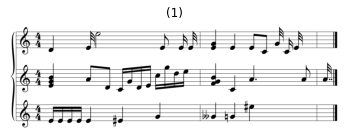

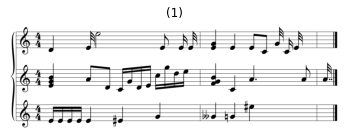

(509, 1583)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


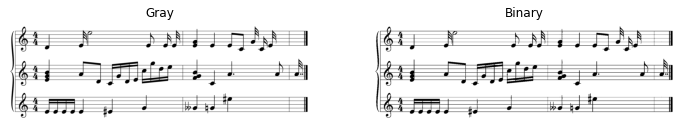

In [ ]:
"""
Read the Image to be recognized and preprocess the image using the preprocessing techniques used when the model was built.
"""
img = io.imread(img_name)
img = gray_img(img)
show_images([img])
# img = get_thresholded(img, threshold_otsu(img))
horizontal = IsHorizontal(img)
if horizontal == False:
    theta = deskew(img)
    img = rotation(img,theta)
    img = get_gray(img)
    img = get_thresholded(img, threshold_otsu(img))
    img = get_closer(img)
    horizontal = IsHorizontal(img)
show_images([img])

#img = io.imread('testcases/test-set-scanned/test-cases/02.PNG')
print(img.shape)
# if img.shape[1] < 1300:
#     img = resize(img, (img.shape[0], 2000))
# if img.shape[0] > 250:
#     img = resize(img, (250, img.shape[1]))
# print(img.shape)
original = img.copy()
gray = get_gray(img)
bin_img = get_thresholded(gray, threshold_otsu(gray))
show_images([gray, bin_img], ['Gray', 'Binary'])

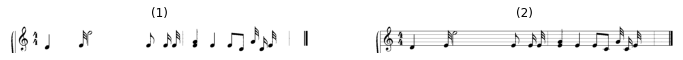

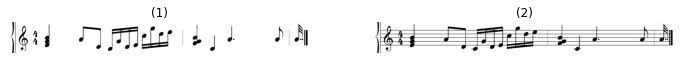

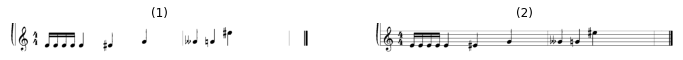

In [ ]:
"""
Segment images into specific regions based on the notes.
"""
segmenter = Segmenter(bin_img)
imgs_with_staff = segmenter.regions_with_staff
imgs_without_staff = segmenter.regions_without_staff

for i, img in enumerate(imgs_without_staff):
    show_images([img, imgs_with_staff[i]])

In [ ]:
"""
Store Coordinates for all the music notes in the images. This can be used later to identify the positions of the music notes.
"""
imgs_spacing = []
imgs_rows = []
coord_imgs = []
for i, img in enumerate(imgs_with_staff):
    spacing, rows, no_staff_img = coordinator(img,horizontal)
    imgs_rows.append(rows)
    imgs_spacing.append(spacing)
    coord_imgs.append(no_staff_img)

22
41
60
79
98
117
136


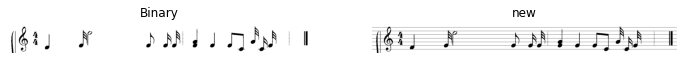

22
41
60
79
98
117
136


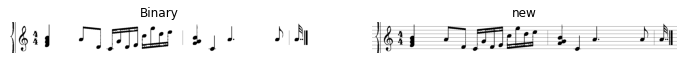

22
41
60
79
98
117
136


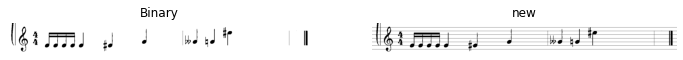

In [ ]:
"""
Draw Staff on the Binary Images and save these images
"""
def draw_staff(img,row_positions):
    image = np.copy(img)
    for x in range (len(row_positions)):
        print(int(row_positions[x]))
        image[int(row_positions[x]),:] = 0
    return image

for i, img in enumerate(coord_imgs):
    new_img = draw_staff(img,imgs_rows[i])
    show_images([img,new_img], ['Binary','new'])  
    cv2.imwrite(f'{img_name}_without_staff_{i}.png', np.array(255*img).astype(np.uint8))
    cv2.imwrite(f'{img_name}_with_new_staff_{i}.png', np.array(255*new_img).astype(np.uint8))

3


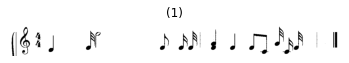

42
Other
18
Beam
42
Other
42
Other
42
Other
43
Quarter-Note
42
Other
39
Multiple-Quarter-Notes
27
Eighth-Note
27
Eighth-Note
42
Other
39
Multiple-Quarter-Notes
43
Quarter-Note
42
Other
42
Other
42
Other
42
Other
18
Beam


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17
Barline


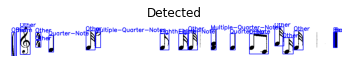

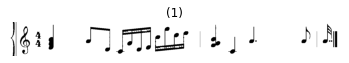

44
Quarter-Rest
18
Beam
42
Other
42
Other
42
Other
43
Quarter-Note
42
Other
42
Other
42
Other
39
Multiple-Quarter-Notes
43
Quarter-Note
43
Quarter-Note
27
Eighth-Note
42
Other
18
Beam


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18
Beam


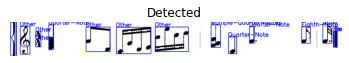

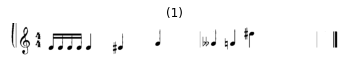

42
Other
18
Beam
32
G-Clef
42
Other
42
Other
24
Dot
43
Quarter-Note
24
Dot
43
Quarter-Note
43
Quarter-Note
42
Other
43
Quarter-Note
18
Beam
43
Quarter-Note
24
Dot
43
Quarter-Note


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18
Beam
17
Barline


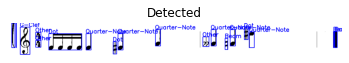

Other Beam G-Clef Other Other Dot Quarter-Note Dot Quarter-Note Quarter-Note Other Quarter-Note Beam Quarter-Note Dot Quarter-Note Beam Barline


In [ ]:
"""
Perform the CLassification based on the input music sheet or sheets
"""
from sklearn.preprocessing import LabelBinarizer

label_names=['Thirty-Two-Rest', 'Sixteenth-Note', 'Dot', 'Cut-Time', 'Quarter-Note', 'Stopped', 'Fermata', '4-8-Time', '7-4-Time', 'Sharp', 'Whole-Half-Rest', '9-8-Time', 'Thirty-Two-Note', '8-8-Time', '2-4-Time', 'Staccatissimo', 'C-Clef', 'G-Clef', 'Turn', 'Half-Note', '12-8-Time', 'Double-Whole-Rest', 'Quarter-Rest', 'Multiple-Quarter-Notes', 'Other', 'Eighth-Rest', '6-4-Time', 'Chord', '5-8-Time', 'Tie-Slur', 'Whole-Note', '4-2-Time', '2-8-Time', 'Mordent', 'Flat', 'Eighth-Note', 'Natural', 'Barline', '3-4-Time', 'Accent', 'Tenuto', 'Tuplet', 'Eighth-Grace-Note', 'Glissando', 'Common-Time', '5-4-Time', 'Multiple-Half-Notes', 'F-Clef', 'Sixteenth-Rest', 'Multiple-Sixteenth-Notes', 'Beam', '4-4-Time', '3-8-Time', 'Multiple-Eighth-Notes', 'Sixty-Four-Note', '6-8-Time', 'Sixty-Four-Rest', 'Marcato', 'Breve', '1-8-Time']
label_names=sorted(label_names)

disk_size = segmenter.most_common / 4
print(len(coord_imgs))
# Iterate through the previously identified coordinates within the images
for i, img in enumerate(coord_imgs):
    show_images([img])
    res = []
    prev = ''
    time_name = ''
    # Pass the individual image of a line of music notes - One single image to get the Primitives, Primitives with Staff and Boundary
    # Boundary to indicate where a note begins and ends. Primitives are each music note.
    primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
    detected = cv2.cvtColor(np.array(255*img.copy()).astype('float32'),cv2.COLOR_GRAY2RGB)
    # Iterate through the primitives that was identified in a single line of music notes.
    for j, prim in enumerate(primitives):
        minr, minc, maxr, maxc = boundary[j]

        # Binary masking on the primitive image of a single music note post segmentation
        prim = binary_opening(prim, square(segmenter.most_common-imgs_spacing[i]))
        # Resize to 32*32
        prim = resize(prim, (32,32))
        # Transform to Float 32 and inverse color
        saved_img = (255*(1 - prim)).astype('float32')
        # Convert from Gray to RGB - Model expects image in 3 Dims (32,32,3)
        saved_img=cv2.cvtColor(saved_img, cv2.COLOR_GRAY2RGB)
        
        # Predict the label of the image using Keras Model
        saved_img=np.expand_dims(saved_img, axis=0) # Expand Dims - Model Expects input as 4 Dim
        # Store IMage in list
        images=[]
        images.append(saved_img)
        # Get Prediction
        predictions = model.predict(images)
        print(np.argmax(predictions))

        # Find Label based on Prediction
        print(label_names[np.argmax(predictions)])
        res.append(label_names[np.argmax(predictions)])

        # Draw the boxes for each detected music note and it's position
        cv2.rectangle(detected, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
        # Add Text (Label) for each Music Note in the image
        cv2.putText(detected, label_names[np.argmax(predictions)], (minc-2, minr-2), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    show_images([detected], ['Detected']) # Display Music Note
    cv2.imwrite(f'detected_{i}.png', detected) # Store Music Note
    
# Final Result
print(' '.join(res))

##### Old Approach

In [ ]:
"""

"""
black_names = ['4', '8', '8_b_n', '8_b_r', '16', '16_b_n', '16_b_r', '32', '32_b_n', '32_b_r', 'a_4', 'a_8', 'a_16', 'a_32', 'chord']
ring_names = ['2', 'a_2']
whole_names = ['1', 'a_1']
label_names=['1-8-Time', '5-4-Time', '7-4-Time', '2-8-Time', '4-8-Time', '8-8-Time', 'Multiple-Sixteenth-Notes', 'Marcato', 'Stopped', 'Quarter-Rest', 'Thirty-Two-Note', 'Sixteenth-Rest', 'F-Clef', '5-8-Time', 'Multiple-Quarter-Notes', 'Sixteenth-Note', '4-4-Time', 'Fermata', 'Multiple-Eighth-Notes', '12-8-Time', '6-8-Time', 'Staccatissimo', '9-8-Time', 'Glissando', 'Barline', 'Half-Note', 'Tie-Slur', 'C-Clef', 'Flat', 'Common-Time', 'Double-Whole-Rest', 'Sixty-Four-Note', 'G-Clef', 'Dot', 'Tenuto', 'Whole-Half-Rest', 'Thirty-Two-Rest', 'Eighth-Note', 'Natural', 'Eighth-Rest', 'Whole-Note', 'Accent', 'Sharp', '2-4-Time', 'Cut-Time', 'Sixty-Four-Rest', 'Mordent', '4-2-Time', 'Chord', 'Quarter-Note', '3-8-Time', 'Eighth-Grace-Note', '3-4-Time', 'Beam', 'Breve', 'Tuplet', '6-4-Time', 'Turn', 'Other', 'Multiple-Half-Notes']
label_nums=[4, 28, 18, 24, 2, 12, 170, 156, 170, 1178, 284, 648, 598, 26, 486, 84, 38, 204, 192, 4, 40, 232, 10, 190, 94, 1346, 932, 678, 1944, 510, 212, 150, 1620, 880, 184, 246, 454, 916, 2190, 1410, 550, 840, 2386, 80, 456, 274, 172, 12, 236, 1826, 54, 28, 164, 2702, 52, 146, 8, 162, 1604, 50]

disk_size = segmenter.most_common / 4
print(len(coord_imgs))
for i, img in enumerate(coord_imgs):
    show_images([img])
    res = []
    prev = ''
    time_name = ''
    primitives, prim_with_staff, boundary = get_connected_components(img, imgs_with_staff[i])
    print(boundary)  
    detected = cv2.cvtColor(np.array(255*img.copy()).astype(np.uint8),cv2.COLOR_GRAY2RGB)
    for j, prim in enumerate(primitives):
        minr, minc, maxr, maxc = boundary[j]

        prim = binary_opening(prim, square(segmenter.most_common-imgs_spacing[i]))
        saved_img = (255*(1 - prim)).astype(np.uint8)

        # Predict the label of the image using Keras Model
        predictions = model.predict(saved_img)
        labels = predict(saved_img)
        octave = None
        label = labels[0]

        cv2.rectangle(detected, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
        cv2.putText(detected, label, (minc-2, minr-2), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        if label in black_names:
            test_img = np.copy(prim_with_staff[j])
            test_img = binary_dilation(test_img, disk(disk_size))
            show_images([prim_with_staff[j], test_img], ['Original', 'Connected Component with staff'])
            comps, comp_w_staff, bounds = get_connected_components(test_img, prim_with_staff[j])
            comps, comp_w_staff, bounds = filter_beams(comps, comp_w_staff, bounds)
            bounds = [np.array(bound)+disk_size-2 for bound in bounds]

            if len(bounds) > 1 and label not in ['8_b_n', '8_b_r', '16_b_n', '16_b_r', '32_b_n', '32_b_r']:
                l_res = []
                bounds = sorted(bounds, key= lambda b : -b[2])
                for k in range(len(bounds)):
                    print("Bound")
                    idx, p = estim(boundary[j][0]+bounds[k][2], i)
                    l_res.append(f'{label_map[idx][p]}/4')
                    if k+1 < len(bounds) and (bounds[k][2]-bounds[k+1][2]) > 1.5*imgs_spacing[i]:
                        print("IF COND", bounds[k][2]-bounds[k+1][2], 1.25*imgs_spacing[i])
                        idx, p = estim(boundary[j][0]+bounds[k][2]-imgs_spacing[i]/2, i)
                        l_res.append(f'{label_map[idx][p]}/4')
                res.append(sorted(l_res))
            else:
                for bbox in bounds:
                    c = bbox[2]+boundary[j][0]
                    line_idx, p = estim(int(c), i)
                    l = label_map[line_idx][p]
                    res.append(get_note_name(prev, l, label))
                    print(c)
                    print(l)
        elif label in ring_names:
            head_img = 1-binary_fill_holes(1-prim)
            head_img = binary_closing(head_img, disk(disk_size))
            comps, comp_w_staff, bounds = get_connected_components(head_img, prim_with_staff[j])
            for bbox in bounds:
                c = bbox[2]+boundary[j][0]
                line_idx, p = estim(int(c), i)
                l = label_map[line_idx][p]
                res.append(get_note_name(prev, l, label))
                print(c)
                print(l)
        elif label in whole_names:
            c = boundary[j][2]
            line_idx, p = estim(int(c), i)
            l = label_map[line_idx][p]
            res.append(get_note_name(prev, l, label))
            print(c)
            print(l)
        elif label in ['bar', 'bar_b', 'clef', 'clef_b', 'natural', 'natural_b'] or label in []:
            show_images([prim], [label])
            continue
        elif label in ['#', '#_b']:
            if prim.shape[0] == prim.shape [1]:
                prev = '##'
            else: 
                prev = '#'
        elif label in ['cross']:
            prev = '##'
        elif label in ['flat', 'flat_b']:
            if prim.shape[1] >= 0.5*prim.shape[0]:
                prev = '&&'
            else:
                prev = '&'
        elif label in ['dot', 'dot_b', 'p', 't24_b']:
            if len(res) == 0 or (len(res) > 0 and res[-1] in ['flat', 'flat_b', 'cross', '#', '#_b', 't24', 't24_b', 't44', 't44_b']):
                continue
            res[-1] += '.'
        elif label in ['t2', 't4']:
            time_name += label[1]
        elif label in []:
            time_name = label[1]+label[2]
        elif label == 'chord':
            print('Chord')
            img = thin(1-prim.copy(), max_iter=20)
            head_img = binary_closing(1-img, disk(disk_size))
        if label not in ['flat', 'flat_b', 'cross', '#', '#_b']:
            prev = ''
        show_images([prim], [label])
        if len(time_name) == 2:
            res = ["\\" + "meter<\"" + str(time_name[0]) + "/" + str(time_name[1])+"\">"] + res
    print(res) 
    show_images([detected], ['Detected'])
    cv2.imwrite(f'{img_name}_detected_{i}.png', detected)